Import modules and csv 

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
from copy import copy
from sklearn.svm import SVR
import warnings
warnings.simplefilter(action="ignore")#, category=SettingWithCopyWarning)

*Preprocessing function needed to clean and normalize the dataset*

In [2]:
def prepare_dataset(df):
  # Casting Date values for representation
  df=df[~(np.abs(df.Volume-df.Volume.mean()) > (3*df.Volume.std()))]
  df['Date'] = pd.to_datetime(df['Date']) #, format='%d%b%Y:%H:%M:%S.%f'
  df['Date'] = df['Date'].map(dt.datetime.toordinal)
  # Drop NaN values
  df = df.dropna(axis=0)
  ratio = df.max()-df.min()
  original_min = df.min()
  # Normalize the Data
  std_dev = df.std()
  mean = df.mean()
  df = (df - df.mean())/df.std()
  X = df['Date']
  ratio = ratio/(df.max()-df.min())
  #print(df.min())
  #print(vecchio_min)
  return df, X, ratio, original_min

function to compute and plot the Linear Regression for 'high' , 'low' , 'open' , 'close' and the Polinomial Regression for Open and data

In [3]:
def ssr_gradient(x, y, b):
    res = b[0] + b[1] * x + b[2] * x**2 + b[3] * x**3 + b[4] * x**4 + b[5] * x**5 - y                            #VERSION WITH 6 VARS
    return res.mean(), (res * x).mean(), (res * x**2).mean(), (res * x**3).mean(), (res * x**4).mean(), (res * x**5).mean() # .mean() is a method of np.ndarray

In [4]:
def sgd(
    x, y, n_vars=None, start=None, learn_rate=0.1,
    decay_rate=0.0, batch_size=1, n_iter=50, tolerance=1e-06,
    dtype="float64", random_state=None
):

    # Setting up the data type for NumPy arrays
    dtype_ = np.dtype(dtype)

    # Converting x and y to NumPy arrays
    x, y = np.array(x, dtype=dtype_), np.array(y, dtype=dtype_)
    n_obs = x.shape[0]
    xy = np.c_[x.reshape(n_obs, -1), y.reshape(n_obs, 1)]

    # Initializing the random number generator
    seed = random_state
    rng = np.random.default_rng(seed=seed)

    # Initializing the values of the variables
    vector = (rng.normal(size=int(n_vars)).astype(dtype_))


    # Setting the difference to zero for the first iteration
    diff = 0

    # Performing the gradient descent loop
    for _ in range(n_iter):
        # Shuffle x and y
        rng.shuffle(xy)

        # Performing minibatch moves
        for start in range(0, n_obs, batch_size):
            stop = start + batch_size
            x_batch, y_batch = xy[start:stop, :-1], xy[start:stop, -1:]

            # Recalculating the difference
            grad = np.array(ssr_gradient(x_batch, y_batch, vector), dtype_)
            diff = decay_rate * diff - learn_rate * grad

            # Checking if the absolute difference is small enough
            if np.all(np.abs(diff) <= tolerance):
                break

            # Updating the values of the variables
            vector += diff

    return vector #if vector.shape else vector.item()

In [5]:
def plot_regression(X , Y, L, epochs, x_argument, y_argument, stamp = True):
    m = 0
    c = 0 
    # Performing Gradient Descent 
    for i in X: 
        n = float(len(X)) # Number of elements in X
        Y_pred = m*X + c  # The current predicted value of Y
        D_m = (-2/n) * sum(X * (Y - Y_pred))  # Derivative wrt m
        D_c = (-2/n) * sum(Y - Y_pred)  # Derivative wrt c
        m = m - L * D_m  # Update m
        c = c - L * D_c  # Update c
    if stamp == True:
      # Making predictions
      plt.scatter(X, Y) 
      # regression line
      plt.plot([min(X), max(X)], [min(Y_pred), max(Y_pred)], color='red')
      plt.xlabel(x_argument)
      plt.ylabel(y_argument)


      plt.show()
    return(m,c)

##-------------------------------##
def plot_mult_regression(df,Y, L, epochs, decay_rate, batch_size, stamp=True):
  X = df.iloc[:, 0] #Date
  n_vars=6
  r = sgd(X, Y, n_vars, learn_rate=L, decay_rate = decay_rate,batch_size = batch_size, n_iter = epochs, random_state=420)
  Y_pred = r[5]*X**5 + r[4]*X**4 + r[3]*X**3 + r[2]*X**2 + r[1]*X + r[0] 
  if stamp == True:
    plt.plot(X,Y, color='b')
    plt.plot(X,Y_pred,color='r')
    plt.xlabel('Date')
    plt.ylabel('Open price')
    plt.show()
  return(r[1],r[2],r[3],r[4],r[5],r[0])

##-------------------------------##
def prediction(y_pred, c, m): 
  return (y_pred - c) / m

Function used to predict all the values of n days after a given dataset

In [6]:
def predict_n_day_after(df, n, stamp = True):
  df_base = df.copy()
  df, X, ratio, original_min = prepare_dataset(df)
  Y = df.iloc[:, 1] #Open
  L = 0.1  # The learning Rate for linear regressions
  decay_rate = 0.001
  batch_size = 5
  epochs = 100  # The number of iterations to perform gradient descent

  m_high, c_high = plot_regression(df.iloc[:, 2], Y, L, epochs, 'High values', 'Open values', stamp = stamp)
  m_close, c_close = plot_regression(df.iloc[:, 4], Y , L , epochs, 'Close values', 'Open values', stamp = stamp)
  m_low, c_low = plot_regression(df.iloc[:, 3], Y , L , epochs, 'Low values', 'Open values', stamp = stamp)
  m_volume, c_volume = plot_regression(df.iloc[:, 5], Y, L, epochs, 'Volume values', 'Open values', stamp = stamp)
  op1,op2,op3,op4,op5,bop = plot_mult_regression(df, df.iloc[:, 1], 0.01, 100, decay_rate, batch_size, stamp=stamp)
  ##now all the curves have been set
  #what we have to do is predict values
  
  unit = 2*X.max()/X.shape[0]
  X_pred =  X.max() + n* unit
  #open
  y_open = (op5*X_pred**5 + op4*X_pred**4 + op3*X_pred**3 + op2*X_pred**2 + op1*X_pred + bop)
  
  # predict other values
  y_high_pred = prediction(y_open, c_high, m_high)
  y_low_pred = prediction(y_open,c_low ,m_low)
  y_close_pred = prediction(y_open, c_close, m_close)
  y_volume_pred = prediction(y_open, c_volume, m_volume)

  
  def denormalize(df, ratio, original_min, y, index):
    y = (abs(y) + abs(df.iloc[:, index].min()))*ratio[index] + original_min[index]
    return y
  y_open = denormalize(df, ratio, original_min, y_open, 1)
  y_high_pred = denormalize(df, ratio, original_min, y_high_pred, 2)
  y_low_pred = denormalize(df, ratio, original_min, y_low_pred, 3)
  y_close_pred = denormalize(df, ratio, original_min, y_close_pred, 4)
  y_volume_pred = denormalize(df, ratio, original_min, y_close_pred, 6)

  if stamp == True:
    print('The opening predicted value is : ' , round(y_open) )
    print('The high predicted value is : ' , round(y_high_pred) )
    print('The low predicted value is : ' , round(y_low_pred))
    print('The close predicted value is : ' , round(y_close_pred) )
    print('The volume predicted value is : ' , round(y_volume_pred) )
  return y_open, y_high_pred, y_low_pred, y_close_pred, y_volume_pred

The function necessary to test the reliability of the polinomial model evaluating slices of 30 days

In [7]:
def rolling_window(df, n_days_after, n_slice):
  loss = []
  for i in range(0,n_slice):
    df_month = df.iloc[30*i:30+30*i].copy()
    true_values = df.iloc[30+30*i+n_days_after].copy() #n is the number of days after we want to predict
    y_open, y_high_pred, y_low_pred, y_close_pred, y_volume_pred = predict_n_day_after(df_month, n_days_after, stamp=False)
    perc_err_open = abs(y_open - true_values['Open'])/true_values['Open']
    perc_err_high = abs(true_values['High']-y_high_pred)/true_values['High']
    perc_err_low = abs(y_low_pred - true_values['Low'])/true_values['Low']
    perc_err_close = abs(true_values['Close'] - y_close_pred)/true_values['Close']
    perc_err_volume = abs(true_values['Volume'] - y_volume_pred)/true_values['Volume']
    if (perc_err_open and perc_err_high and perc_err_low and perc_err_close and perc_err_volume) >0:
      loss.append([perc_err_open, perc_err_high, perc_err_low, perc_err_close, perc_err_volume])
  mean_loss_open, mean_loss_high, mean_loss_low, mean_loss_close, mean_loss_volume = 0, 0, 0, 0, 0
  for i in range(0, len(loss)):
    mean_loss_open = mean_loss_open + loss[i][0]
    mean_loss_high = mean_loss_high + loss[i][1]
    mean_loss_low = mean_loss_low + loss[i][2]
    mean_loss_close = mean_loss_close + loss[i][3]
    mean_loss_volume = mean_loss_volume + loss[i][4]
  mean_loss_open = round(mean_loss_open / len(loss)*1000)/10
  mean_loss_high = round(mean_loss_high / len(loss)*1000)/10
  mean_loss_low = round(mean_loss_low / len(loss)*1000)/10
  mean_loss_close = round(mean_loss_close / len(loss)*1000)/10
  mean_loss_volume = round(mean_loss_volume / len(loss)*1000)/10
  print('the mean of the error for open is: ', mean_loss_open, '%')
  print('the mean of the error for high is: ', mean_loss_high, '%')
  print('the mean of the error for low is: ', mean_loss_low, '%')
  print('the mean of the error for close is: ', mean_loss_close, '%')
  print('the mean of the error for volume is: ', mean_loss_volume, '%')

Finally we can start with the regressions

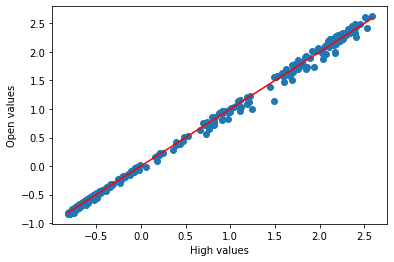

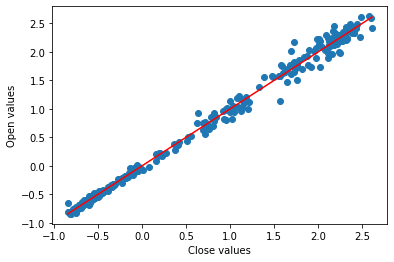

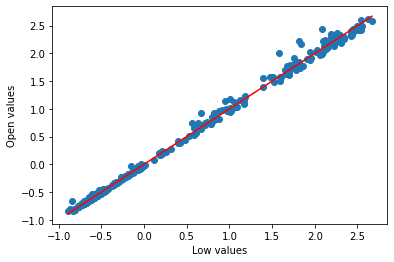

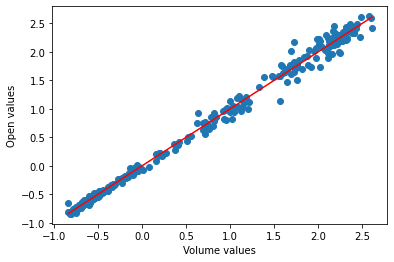

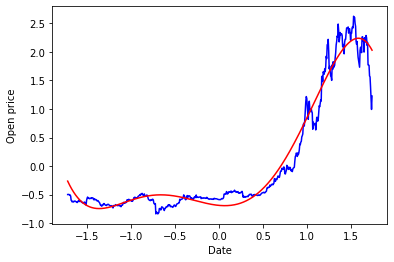

The opening predicted value is :  44546
The high predicted value is :  45924
The low predicted value is :  43092
The close predicted value is :  44693
The volume predicted value is :  683182166340992


In [8]:
df_base = pd.read_csv("BTC-EUR.csv" , sep = ',')
df = df_base.copy()
n_days_after = 1
y_open, y_high_pred, y_low_pred, y_close_pred, y_volume_pred = predict_n_day_after(df, n_days_after)

Testing the reliability of the model using a rolling window

In [9]:
df = df_base.copy()
n_slice = int(df.shape[0]/30)
print('The percentage of error of the polynomial regression curve with respect to the entire dataset in slices of 30 days')
rolling_window(df, n_days_after, n_slice)

The percentage of error of the polynomial regression curve with respect to the entire dataset in slices of 30 days
the mean of the error for open is:  16.5 %
the mean of the error for high is:  15.7 %
the mean of the error for low is:  18.9 %
the mean of the error for close is:  17.7 %
the mean of the error for volume is:  422391.8 %


Comparing the effectiveness of the regression curve with respect to the ones generated with the Support Vector Regressor

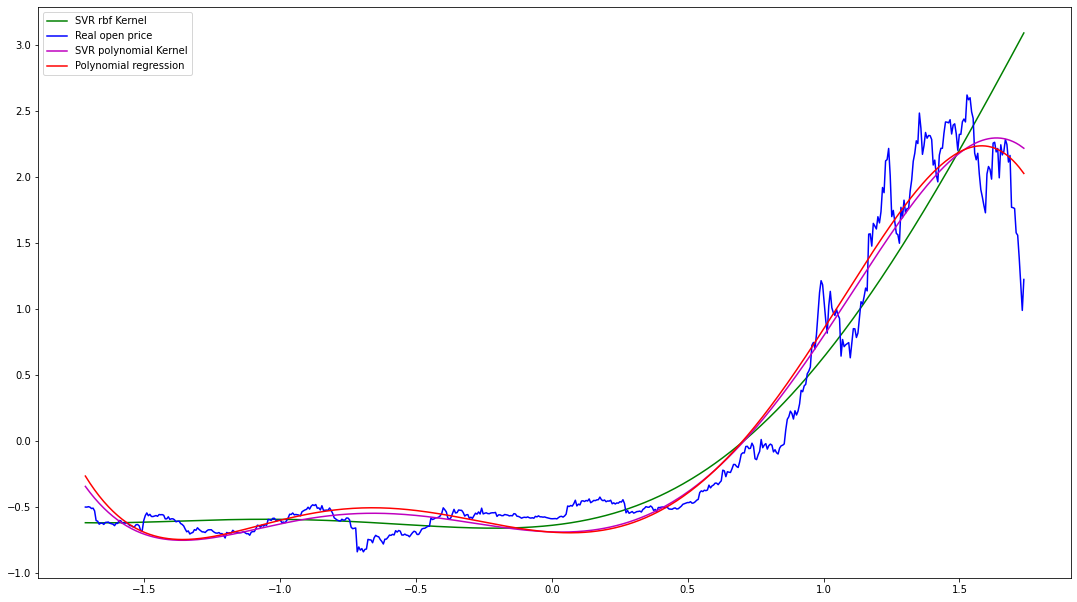

In [10]:
df = df_base.copy()
df, X, std_dev, mean = prepare_dataset(df)

# Initialise the SVR
svr_rbf = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
svr_poly = SVR(kernel='poly', C=100, gamma='auto', degree=5, epsilon=.1,coef0=1)

# Split the data
X = np.array(X).reshape(-1, 1) #Date
y = np.array(df.iloc[:, 1]) #Open

# Generate the polynomila regression curve
op1,op2,op3,op4,op5,bop = plot_mult_regression(df, df.iloc[:, 1], 0.01, 100, decay_rate=0.001, batch_size=5, stamp=False)
Y_pred = op5*X**5 + op4*X**4 + op3*X**3 + op2*X**2 + op1*X + bop
#plot and compare results
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.plot(X, svr_rbf.fit(X, y).predict(X), color='g', label='SVR rbf Kernel')
ax.plot(X, df.iloc[:, 1], color='b', label='Real open price')
ax.plot(X, svr_poly.fit(X, y).predict(X), color='m', label='SVR polynomial Kernel')
ax.plot(X, Y_pred,color='r', label='Polynomial regression')
leg = ax.legend()
plt.show()